In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob

In [2]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'

In [3]:
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [4]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [5]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [6]:
tas = masked_tas['tas'].loc[:,'2008-01-01':'2022-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_climatology
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano_ds = tas_ano.to_dataset()
tas_ano_ds
# print(tas_ano.min().values)

-49.660248


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 180, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [7]:
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_ano_ds.sel(time=tas.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_ano_ds['JJA'] = season_means['JJA']
tas_ano_ds['DJF'] = season_means['DJF']
tas_ano_ds['MAM'] = season_means['MAM']
tas_ano_ds['SON'] = season_means['SON']

tas_ano_ds


<xarray.Dataset>
Dimensions:  (time: 180, lon: 180, lat: 45, run: 30, year: 15)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 2008 2009 2010 2011 2012 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [8]:
year = np.arange(2008,2023,1)
year

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

In [9]:
import numpy as np
import xarray as xr
import scipy.stats as stats
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value


In [10]:
tas_ano_ds['slope_JJA'], tas_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, tas_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_JJA'].attrs['units'] = '°C/15yrs'
tas_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

In [11]:
tas_ano_ds['slope_DJF'], tas_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, tas_ano_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_DJF'].attrs['units'] = '°C/15yrs'
tas_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

In [12]:
tas_ano_ds['slope_MAM'], tas_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, tas_ano_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_MAM'].attrs['units'] = '°C/15yrs'
tas_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'


In [13]:
tas_ano_ds['slope_SON'], tas_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, tas_ano_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_SON'].attrs['units'] = '°C/15yrs'
tas_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

In [14]:
tas_ano_ds = tas_ano_ds.compute()

## calculate the seasonal mean 

In [15]:
slope_JJA = tas_ano_ds['slope_JJA'] 
slope_DJF = tas_ano_ds['slope_DJF']
slope_MAM = tas_ano_ds['slope_MAM']
slope_SON = tas_ano_ds['slope_SON']

p_value_JJA = tas_ano_ds['p_value_JJA']
p_value_DJF = tas_ano_ds['p_value_DJF']
p_value_MAM = tas_ano_ds['p_value_MAM']
p_value_SON = tas_ano_ds['p_value_SON']

In [16]:
slope_JJA_data = slope_JJA*15.0
slope_DJF_data = slope_DJF*15.0
slope_MAM_data = slope_MAM*15.0
slope_SON_data = slope_SON*15.0

In [23]:
slope_DJF_data.min().values

array(-7.60784638)

In [18]:
slope_JJA_data.min().values

array(-4.64659884)

In [19]:
# slope_JJA['lon'], slope_JJA['lat'], slope_JJA['run'] 

In [20]:
slope_JJA_MME = slope_JJA_data.mean(dim='run')
slope_DJF_MME = slope_DJF_data.mean(dim='run')
slope_MAM_MME = slope_MAM_data.mean(dim='run')
slope_SON_MME = slope_SON_data.mean(dim='run')

p_value_JJA_MME = p_value_JJA.mean(dim='run')

In [25]:
print(slope_DJF_MME.min().values)

-1.4330952990093335


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is d

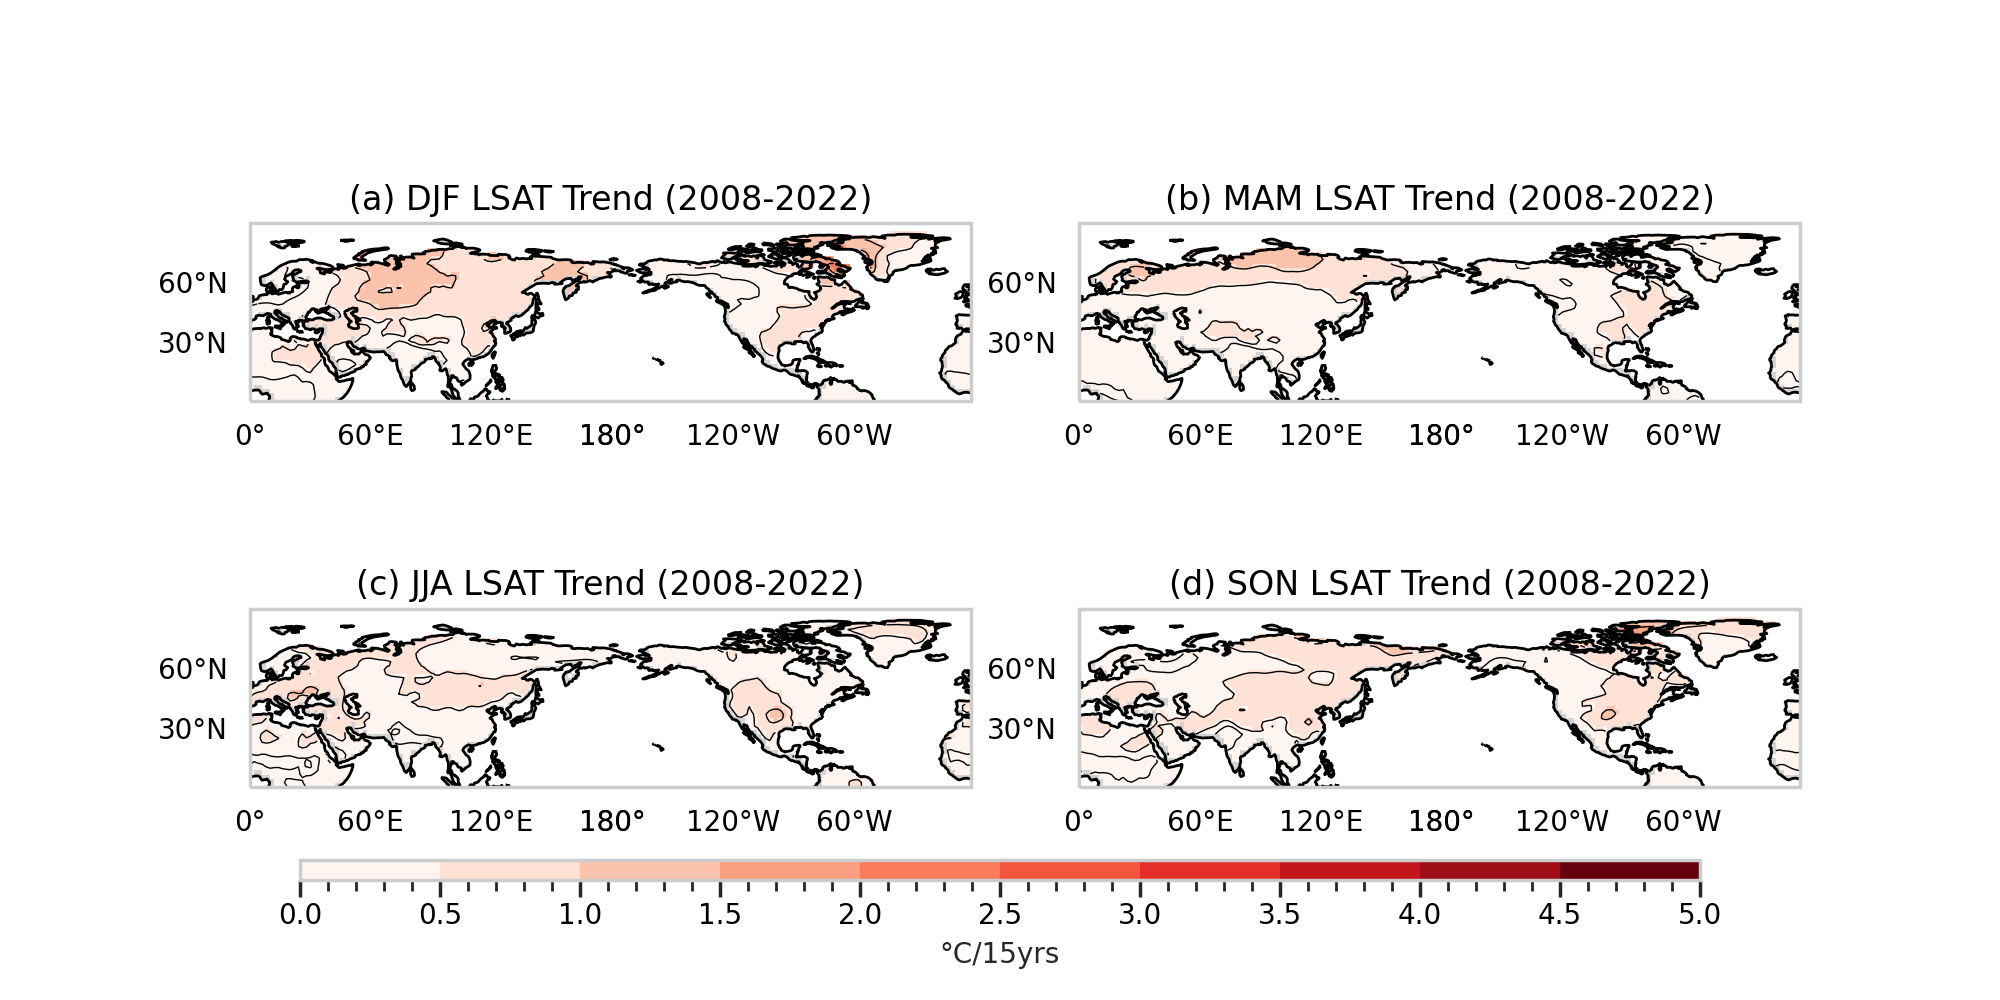

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

sns.set_theme(style="whitegrid")

# Define the levels and colormap
levels = np.arange(0, 5.5, 0.5)
cmap = plt.cm.get_cmap('Reds', len(levels) - 1)

sig_levels = np.array([-0.05, 0.05])
sig_cmap = ListedColormap(['none', 'none'])

# Define the figure and each axis for the 30 subplots
fig = plt.figure(figsize=(10, 5))
gs = plt.GridSpec(2, 2, hspace=0.005, wspace=0.15, figure=fig)

# Loop through each season and plot the data
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    trend_data = globals()[f'slope_{season}_MME']
    # Create a new subplot for the current season
    ax = fig.add_subplot(gs[i//2, i%2], projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.coastlines()
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.set_title(season, fontsize=10, fontweight='medium')
    
    im = ax.pcolormesh(trend_data['lon'], trend_data['lat'], trend_data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0., vmax=5.0, norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    contours = ax.contour(trend_data['lon'], trend_data['lat'], trend_data, transform=ccrs.PlateCarree(), levels=levels, colors='black', linewidths=0.5)

    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.tick_params(labelsize=10)
    # Remove x label for upper plots and y label for right plots
    if i in [0, 1]:
        ax.set_xlabel('')
    if i in [1, 3]:
        ax.set_ylabel('')
    # Set the title of the plot
    plt.title(f'({chr(97+i)}) {season} LSAT Trend (2008-2022)')

# Add a colorbar to the figure for trend values
trend_cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.02])
trend_cbar = fig.colorbar(im, cax=trend_cbar_ax, orientation='horizontal', ticks=levels)
trend_cbar.ax.tick_params(labelsize=10)
trend_cbar.set_label('°C/15yrs', fontsize=10)

# Save the figure
plt.savefig('MPI-ESM-MME-seasonal_15yrs_trend_pattern.png', dpi=300, bbox_inches='tight')
plt.show()


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is d

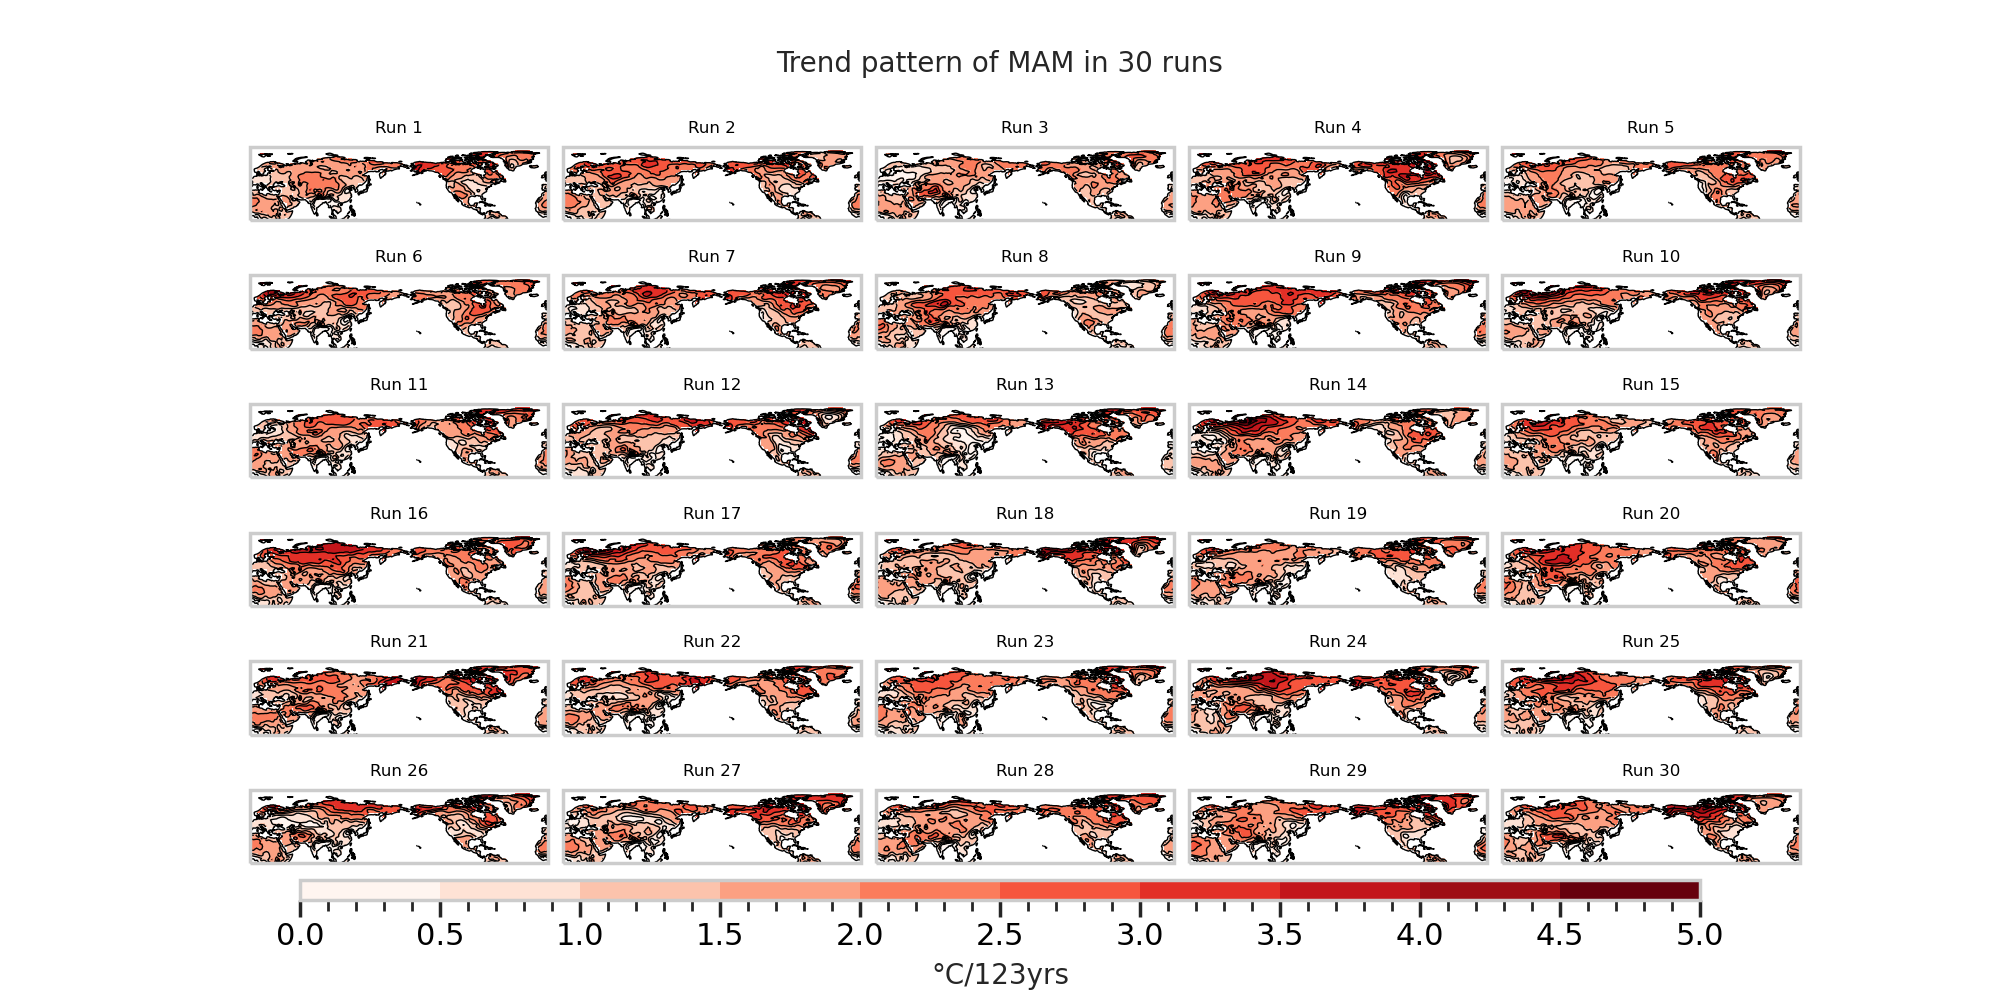

In [125]:
#Plotting the trend pattern of JJA in 30 runs and the p_value of the trend pattern of JJA in 30 runs 
# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.ticker as mticker
# import cartopy.feature as cfeature
# import cartopy.mpl.ticker as cticker
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines
# import matplotlib.gridspec as gridspec
# import matplotlib as mpl
# import seaborn as sns
# from matplotlib.colors import ListedColormap
# from matplotlib.colors import BoundaryNorm, ListedColormap

# sns.set_theme(style="whitegrid")

# # Define the levels and colormap
# levels = np.arange(0, 5.5, 0.5)
# cmap = plt.cm.get_cmap('Reds', len(levels) - 1)

# sig_levels = np.array([-0.05, 0.05])
# sig_cmap = ListedColormap(['none', 'none'])

# # Define the figure and each axis for the 30 subplots
# fig = plt.figure(figsize=(10, 5))
# grid = plt.GridSpec(6, 5, hspace=0.015, wspace=0.05, figure=fig)

# for i in range(30):
#     # Select the data for the current run
#         data = slope_MAM_data.sel(run=i)
#         sig_data = p_value_MAM.sel(run=i)
#         # Add the axis for the current run
#         ax = fig.add_subplot(grid[i], projection=ccrs.PlateCarree(central_longitude=180))

#         # Add coastlines and borders
#         ax.coastlines(linewidth=0.5)
#         # ax.add_feature(cfeature.BORDERS, linewidth=0.5)

#         # Add filled contours
#         im = ax.pcolormesh(data['lon'], data['lat'], data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0., vmax=5.0, norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True))
#         contours = ax.contour(data['lon'], data['lat'], data, transform=ccrs.PlateCarree(), levels=levels, colors='black', linewidths=0.5)

#         # Add contour lines
#         # ax.contour(data['lon'], data['lat'], sig_data, levels=sig_levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())

#         # Set the title for the subplot
#         ax.set_title('Run {}'.format(i + 1), fontsize=6)

#         # Add the land and ocean features
#         # ax.add_feature(cfeature.LAND, facecolor='lightgray')
#         # ax.add_feature(cfeature.OCEAN, facecolor='white')
    

#         # Set the extent of the map to cover the whole globe
#           # Add latitude and longitude labels to the x and y axe


# # Add a big title at the top
# fig.suptitle('Trend pattern of MAM in 30 runs', fontsize=10, fontweight='medium', y=0.95)

# # Add colorbar
# cbar_ax = fig.add_axes([0.15, 0.10, 0.7, 0.02])
# cbar = plt.colorbar(im, cax=cbar_ax, cmap=cmap, orientation='horizontal', ticks=levels)
# cbar.set_label('°C/123yrs', fontsize=10)


# plt.show()


In [126]:
fig.savefig('123yr-Trend pattern of MAM in 30 runs.png', dpi=300, bbox_inches='tight')